## Import Libraries

In [1]:
import sys 
sys.path.append('C:/Users/yemre/Masaüstü/Data_Science_Projects/Churn_Prediction/src')

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import warnings

from data_analysis import DataAnalysis
from data_preprocessor import Preprocessor
from dataloader import DataLoader
from model_trainer import ModelTrainer
from model_evaluator import ModelEvaluator


import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings("ignore")


## Load data and Preprocessing

#

In [3]:
data = DataLoader.get_data('../data/dataset.csv')

Data loaded from file path ../data/dataset.csv


In [4]:
# Total Charges column has a object data type but it is numerical data, so let's change data type for this column.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')



data_na = (data.isnull().sum() / len(data)) 
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'mean of nulls' :data_na, "number of nulls" : data[data_na.index].isna().sum()})
missing_data

,mean of nulls,number of nulls
TotalCharges,0.001562,11


In [5]:
data[data['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [6]:
# we have the number of months that the customer uses the service, Tenure Months, and Monthly Charges. we can replace null values with those calculated by monthly charges * tenure months
data['TotalCharges'].fillna(data['MonthlyCharges'] * data['tenure'], inplace=True)

Low cordinality/Constant Column: 

A column that has the same value for every row in a dataset is often considered uninformative and can be a problem in data analysis or machine learning, as it doesn't provide any information.

High Cardinality: 

When each row in a dataset has a unique value. High cardinality features can present challenges for modeling, as they can lead to a large number of unique categories, which can make the data more difficult to work with.

In [7]:
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

The data has many constant features and columns with high cardinality problem.

Low cordinality columns:

Count column
Country column
State column
High cordinality columns:

CustomerID column.
Zip Code column.

In [8]:


numeric_cols, categoric_cols, date_cols =DataAnalysis.categorize_columns(data)
# numeric_stats = DataAnalysis.descriptive_stats_for_numeric_cols(data[numeric_cols])
# categoric_stats = DataAnalysis.description_for_categoric_cols(data[categoric_cols])



do2


In [9]:
# preprocessing
#  Handle missing values, duplicate data, and feature scaling here

Preprocessor.check_duplicate_cols(data)
Preprocessor.check_duplicate_rows(data)
data[numeric_cols] = Preprocessor.robust_scaler(data[numeric_cols])

In [10]:
# encode categorical data using one-hot encoding or label encoding
cols_to_use = ["InternetService",  "Contract", "PaymentMethod",]


for column in cols_to_use:
    data = Preprocessor.one_hot_encoder(data, column)


cols = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies","PaperlessBilling", "Churn"]
for column in cols:
    data = Preprocessor.label_encoder(data, column)
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [11]:
# calculate gini value
del data['customerID']
y = data['Churn']
X = data.drop('Churn', axis=1)

X_train, X_test, y_train, y_test = Preprocessor.split_data(X, y)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   int64  
 1   SeniorCitizen                            7043 non-null   float64
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   float64
 5   PhoneService                             7043 non-null   int64  
 6   MultipleLines                            7043 non-null   int64  
 7   OnlineSecurity                           7043 non-null   int64  
 8   OnlineBackup                             7043 non-null   int64  
 9   DeviceProtection                         7043 non-null   int64  
 10  TechSupport                              7043 no

In [12]:
Preprocessor.calculate_univariate_gini(data,'Churn', X_test, y_test)


{'gender': -0.014660673228448218,
 'SeniorCitizen': 0.12083494794492244,
 'Partner': 0.18106641866232676,
 'Dependents': 0.18436539306104516,
 'tenure': 0.5249890206411947,
 'PhoneService': 0.004967836937146419,
 'MultipleLines': 0.07100674261799567,
 'OnlineSecurity': 0.4083804799917332,
 'OnlineBackup': 0.35029063008602623,
 'DeviceProtection': 0.348725102689297,
 'TechSupport': 0.42286806685783684,
 'StreamingTV': 0.24794233899093232,
 'StreamingMovies': 0.24163372859025034,
 'PaperlessBilling': 0.194972745356377,
 'MonthlyCharges': 0.43467152341832627,
 'TotalCharges': 0.43113229481515924,
 'InternetService_DSL': 0.13675372652354745,
 'InternetService_Fiber optic': 0.35239350021958726,
 'InternetService_No': 0.2156397736960396,
 'Contract_Month-to-month': 0.45568214110413585,
 'Contract_One year': 0.15198532640987894,
 'Contract_Two year': 0.30369681469425713,
 'PaymentMethod_Bank transfer (automatic)': 0.1220568859955049,
 'PaymentMethod_Credit card (automatic)': 0.139716861711746

## Experiment on Different Models

We have many models to use:

1. xgboost

2. Random Forest

3. Logistic regression

Cross Validation Score :  82.19%
ROC_AUC Score :  69.10%
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



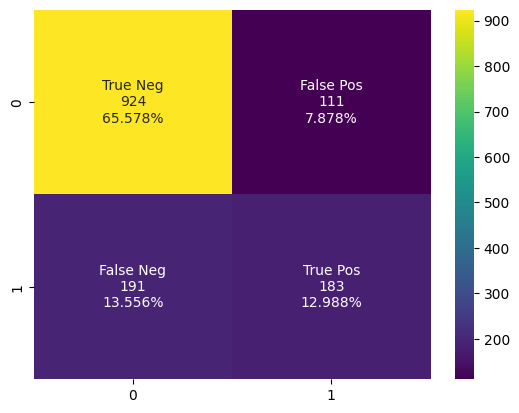

In [17]:
xgb = xgb.XGBClassifier()

ModelTrainer(xgb, X_train,y_train, X_test,y_test)
ModelEvaluator(xgb,X_test,y_test)

Cross Validation Score :  84.40%
ROC_AUC Score :  72.40%
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



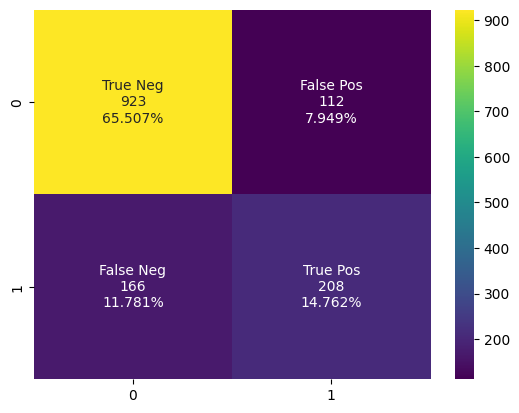

In [15]:
LR = LogisticRegression()

ModelTrainer(LR, X_train,y_train, X_test,y_test)
ModelEvaluator(LR,X_test,y_test)

Cross Validation Score :  82.49%
ROC_AUC Score :  68.49%
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.62      0.47      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



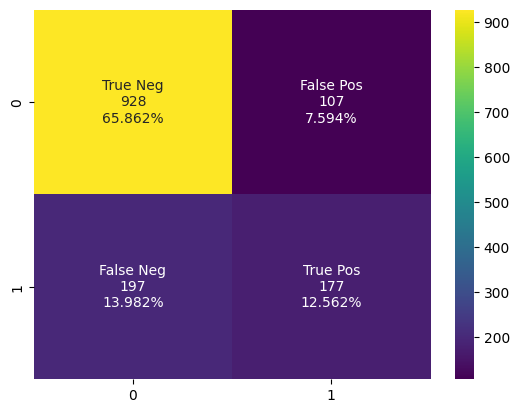

In [16]:
RanForCla = RandomForestClassifier()

ModelTrainer(RanForCla,X_train,y_train,X_test,y_test)
ModelEvaluator(RanForCla, X_test,y_test)